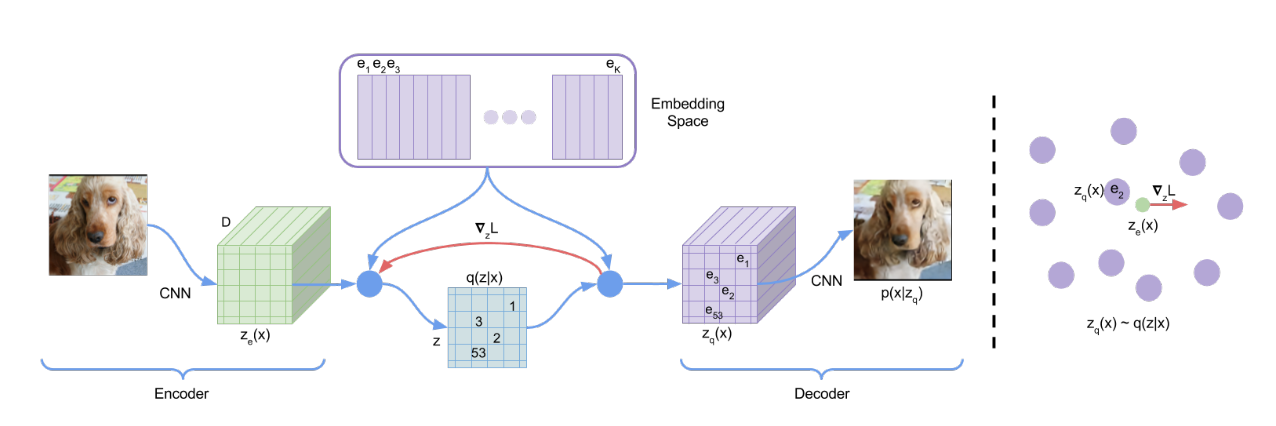

Variational AutoEncoder maps data to a continuous gaussian distribution. The penalty we pay for this is, we are learning interpolation between classes that don't make sense. If you have a dataset of Cats and Cars, the model will not only learn the data distribution of them, but also try to learn the distribution of Cat-Car hybirds.

In VQ-VAE instead of mapping into guassian distribution we will map discrete distribution


Central part: This is a discrete set of learnable vectors (or "codewords"). Each vector $eᵢ$ has the same dimensionality as the encoder's output $zₑ(x)$ at each spatial location. The total number of vectors in the codebook is K.
We then compare continuous $Z$ to all our available discrete codevectors inside our codebook, and pick the codevector that is closest to our continous vector $Z$.
The discrete vector is then passed to our decoder and the original image is reconstructed




**Broken Derivitive of VQ-VAE**: We need to find the closet vector between $z$ and $e$, meaning there is now a $min$ operation in our chain of computations. $min$ is a non-differentiable function, therefore this will break backpropagation
$$L = \log p(x|z_q(x)) + ||sg[z_e(x)] - e||_2^2 + \beta||z_e(x) - sg[e]||_2^2$$



Sample of derivation of the loss function
$$e_i = \mathop{\min}\limits_{i}[(z-e)^2]$$

$$\frac{de}{dz}[(z - \mathop{\min}\limits_{i}[(z-e)^2])^2]$$

$$2*(z - \mathop{\min}\limits_{i}[(z-e)^2])\frac{de}{dz}\mathop{\min}\limits_{i}[(z-e)^2]$$

Here we end up with the derivitive of the $min$ function since there is no derivitive of the $min$ function we are forced to skip over the $min$ function by treating it as a constant.

#### Disecting the Loss Function

Lets go through our loss function piece by piece. The VQ-VAE paper has three losses added together for this to work:

- **Reconstruction Loss**: Just like our regular autoencoder, we need to make sure our output looks like the input, so we have a Mean Squared Error Reconstruction loss
- **Codebook Loss**: Because we cannot compute derivatives between our encoder output $z$ and our quantized latent $e$ due to the $min$ operation, we have to take different approach. What we do know is that $e$ should be somewhat close to $z$, afterall, $e$ is attempting to clump $z$ together into clusters. Therefore, whatever the output of $z$ may be, we need to ensure that $e$ is close to it, or the mean squared error between $e$ and $z$ is small. This will include a stop gradient, and we will treat $z$ like a constant (with no chaining into the operation), and update $e$ such that it minimized the distance between itself and $z$.
- **Commitment Loss**: We actually have to go the other way too. Codebook loss ensures that our quantized embeddings are moving closer to the output of the encoder. But the mean squared error method used in the codebook loss ends up learning the codebook slower than the rest of the parameters in the model in practice. Remember, the encoders job is to create continuous latent vectors that seperate out classes from one another. If we had only two classes, the encoder will theoretically push one towards $\infty$ and the other towards $-\infty$, seperating out the classes as far as possible. The codevectors will then chase after these (as the codebook loss minimizes the difference between codevectors and the output of the encoder) and then also diverge! Therefore, another loss needs to be included, where the output of the encoder $z$ needs to be close to our quantized embeddings $e$! This is exactly the reverse of the codebook loss, and because we want gradients on $z$ we have to hold our $e$ constant, so the stop gradient is applied to $e$ this time. The reason we have this term seperated out is we also include a weight to the commitment loss (set to 0.25 in the paper). This is because it is important to allow the encoder to seperate out the classes, just not too much so we lower the penalty.

So a recap, we have three componets to the losses:
- Reconstruction Loss: $ \log p(x|z_q(x))$ ensures our output looks like the input and we will use Mean Squared Error
- Codebook Loss: $||sg[z_e(x)] - e||_2^2 $ will update our codevectors in the codebook by moving them closer to the output of the encoder $z$, while not drilling down into the $min$ function by placing a stop gradient on $z$
- Commitment Loss: $\beta||z_e(x) - sg[e]||_2^2$ is exactly the opposite of our codebook loss, but ensures the output of the encoder is close to our codevectors, and has a weight $\beta$ to allow for some divergence.


In [1]:
!pip install torchview

In [2]:
from torchview import draw_graph
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
from IPython.display import HTML
from sklearn.manifold import TSNE
import torch.nn.functional as F
from six.moves import xrange
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader


In [3]:
device = torch.device("cpu")

In [4]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


In [5]:
data_variance = np.var(training_data.data / 255.0)

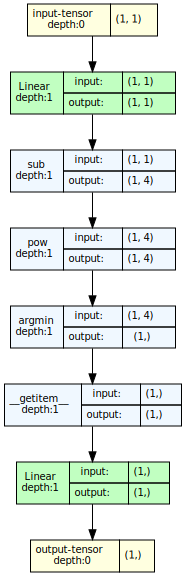

In [6]:
class Quantize(nn.Module):
  def __init__(self):
    super().__init__()
    self.enc = nn.Linear(1,1)
    self.codebook = nn.Parameter(torch.tensor([-10.,0.,4.,3.]))
    self.dec = nn.Linear(1,1)

  def forward(self,x):
    z = self.enc(x)
    closest = torch.argmin((z-self.codebook)**2,dim = -1)
    e_j = self.codebook[closest]
    d = self.dec(e_j)
    return d



q = Quantize()
x = torch.ones(1).unsqueeze(0)
out = q(x)
out.backward()

model_graph = draw_graph(q, input_size = (1,1))
model_graph.visual_graph

#### Passing The gradient from decoder to encoder


In [7]:
print(q.enc.weight.grad)

None


We can see that the gradient didn't make it back to $Z$. But we still need to perform backpropagation through this whole system. The proposed solution from the paper was to use a straight through estimator, where we will copy the gradients from the input of the decoder to the output of the encoder

During backpropagation, we have to find the following derivatives (with super forced notation but should give some insight).

- Derivative of the Decoder w.r.t *codes* (this is totally possible as this is just a regular neural network)
- Derivative of the *codes* w.r.t *Z* (this is not allowed, there is a min operation in there which will break the gradient)
- Derivative of *Z* w.r.t the Encoder (again totally allowed as this is a regular neural network)


So the problem, we need to go from *codes* back to *z* without actually going through that computational graph in between, and so we will use the *straight-through* estimator. Just copy all the gradients from *codes* back to *z*, so we bypass all non-differentiability between them.


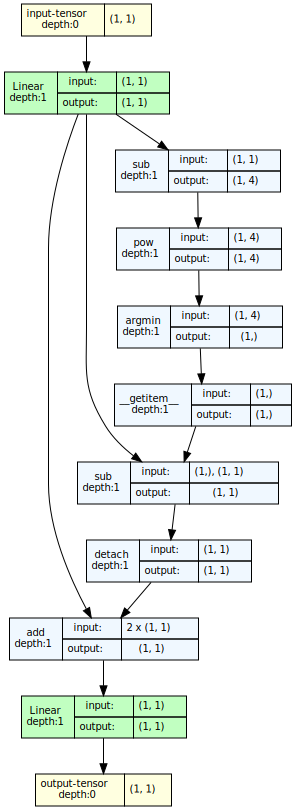

In [8]:
class Quantize(nn.Module):
  def __init__(self):
    super().__init__()
    self.enc = nn.Linear(1,1)
    self.codebook = nn.Parameter(torch.tensor([-10.,0.,4.,3.]))
    self.dec = nn.Linear(1,1)

  def forward(self,x):
    z = self.enc(x)
    closest = torch.argmin((z-self.codebook)**2,dim = -1)
    e_j = self.codebook[closest]
    e_j = z+(e_j-z).detach()

    d = self.dec(e_j)
    return d



q = Quantize()
x = torch.ones(1).unsqueeze(0)
out = q(x)
out.backward()

model_graph = draw_graph(q, input_size = (1,1))
model_graph.visual_graph

In [9]:
print(q.enc.weight.grad)

tensor([[0.7707]], device='cuda:0')


#### Vector Quantizer

The first step is vector quantizer. The expected shape will be (batch_size x Latent dim). Can happen in two ways:

- Our NN encoder will output a batch x latent dim

- Our Convolutional Neural Network encoder will output Batch x Latent_channels x Height x Width. We will have to do some manipulation to quantize every pixel across the channels for all the images in the batch
    - [B,L,H,W] => [B,H,W,L] => [B\*H\*W,L]

    As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

**Computing Distances**: our goal is to compute the distance between our input and $x$ and **All** codebook vectors $e$, so $(x-e)^2$

There are two ways we can compute distances, so follow the shapes of the tensors, but here is the high level idea, our goal is to compute the mean squared distance between our input $x$ and **ALL** codevectors $e$, so $(x-e)^2$. In the naive method, we will have to do matrix inflation to get all our shapes to line up, but this is costly. The better way is to rewrite $(x-e)^2$ as $x^2 - 2xe + e^2$ and just do a couple matrix multiplications to get the same output!  


**Finding the Closest Vector**
Now that we have the distances, we can use *argmin* to find the index of the closest vector and grab those vectors via matrix multiplication. Lets say we have the following embedding vectors:


$$E = \left[\begin{matrix} a & b & c \\ d & e & f \\ g & h & i \end{matrix}\right]$$

Lets also say we pass in two samples and the first sample is closest to the first embedding vector and second sample is closest to the third embedding vector. We can then create a matrix like this, indicating for every batch, which matrix we want:

$$i = \left[\begin{matrix} 1 & 0 & 0 \\ 0 & 0 & 1 \end{matrix}\right]$$

Then multiplying $i$ by $E$, we can get:

$$i \cdot E = \left[\begin{matrix} 1 & 0 & 0 \\ 0 & 0 & 1 \end{matrix}\right] \cdot \left[\begin{matrix} a & b & c \\ d & e & f \\ g & h & i \end{matrix}\right] = \left[\begin{matrix} a & b & c \\ g & h & i \end{matrix}\right]$$

Which grabs the corresponding embedding vectors! The only reason we did it this way is because we can basically "index" out giant embedding matrix with a simple matrix multiplication rather than for loops or annoying indexing.

In [10]:
class VectorQuantizer(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, commitment_cost):
    super().__init__()

    self._num_embeddings = num_embeddings
    self._embedding_dim = embedding_dim
    self._commitment_cost = commitment_cost # 'Beta' part in the commitment loss function

    self._embedding = nn.Embedding(self._num_embeddings,self._embedding_dim)
    self._embedding.weight.data.uniform_(-1/self._num_embeddings,1/self._embedding_dim)


  def forward(self, input):
     # Convert input from (Batch, channels, height, width) --> (Batch, height, width, channels)
     inputs = input.permute(0,2,3,1).contiguous() # Encoded vectors
     input_shape = inputs.shape

     # Flatten input
     flat_input = inputs.view(-1,self._embedding_dim)

     # Calculate distances
     distances = (torch.sum(flat_input**2, dim = 1, keepdim = True)+
                  torch.sum(self._embedding.weight**2, dim = 1)
                  -2*torch.matmul(flat_input,self._embedding.weight.t())) # .t() performs transpose operations

     encoding_indices = torch.argmin(distances, dim = 1).unsqueeze(1)
     encodings = torch.zeros(encoding_indices.shape[0],self._num_embeddings, device=input.device)
     encodings.scatter_(1,encoding_indices,1)
     """
     Tensor.scatter_(dim, index, src, *, reduce=None) --> Tensor
     Writes all values from the tensor src into self at the indices specified in the index tensor.
     For each value in src, its output index is specified by its index in src for dimension != dim and by the corresponding
     value in index for dimension = dim.

     scatter_ is an in-place operation.

     This sets a 1 in each row at the index specified by encoding_indices.
     """
     quantized  = torch.matmul(encodings,self._embedding.weight).view(input_shape) # Codebook vectors

     # Loss
     e_latent_loss = F.mse_loss(quantized.detach(), inputs) # Commitment Loss
     q_latent_loss = F.mse_loss(quantized, inputs.detach()) # Codebook Loss
     loss= q_latent_loss + self._commitment_cost*e_latent_loss
     """
     torch.nn.functional.mse_loss(input, target): Measures the element-wise mean squared error, with optional weighting.
     """

     quantized = inputs + (quantized-inputs).detach() # Copying gradients

     avg_probs = torch.mean(encodings, dim = 0)
     perplexity = torch.exp(-torch.sum(avg_probs*torch.log(avg_probs+1e-10)))

     # Convert quantized form (Batch, Height, Width, Channels) --> (Batch, Channels, Height, Width)
     return loss, quantized.permute(0,3,1,2).contiguous(), perplexity, encodings

####Residual layer

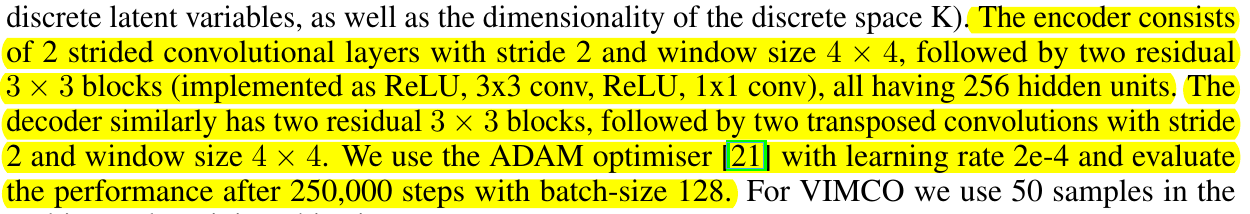

In [11]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

####Encoder

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

####Decoder

In [13]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

####Train

In [14]:
batch_size = 256
num_training_updates = 7000
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.25
learning_rate = 1e-3

In [15]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [16]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [17]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost)

In [18]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate, amsgrad=False)

In [19]:
model.train()

Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (_vq_vae): VectorQuantizer(
    (_embedding): Embedding(512, 64)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleLis

In [20]:
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()
    data = data.to(device)

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.755
perplexity: 1.978

200 iterations
recon_error: 0.508
perplexity: 2.938

300 iterations
recon_error: 0.376
perplexity: 3.341

400 iterations
recon_error: 0.337
perplexity: 3.845

500 iterations
recon_error: 0.294
perplexity: 4.979

600 iterations
recon_error: 0.280
perplexity: 6.770

700 iterations
recon_error: 0.265
perplexity: 9.578

800 iterations
recon_error: 0.256
perplexity: 12.601

900 iterations
recon_error: 0.251
perplexity: 16.301

1000 iterations
recon_error: 0.238
perplexity: 20.331

1100 iterations
recon_error: 0.232
perplexity: 24.334

1200 iterations
recon_error: 0.227
perplexity: 27.885

1300 iterations
recon_error: 0.205
perplexity: 31.561

1400 iterations
recon_error: 0.188
perplexity: 35.432

1500 iterations
recon_error: 0.180
perplexity: 39.446

1600 iterations
recon_error: 0.173
perplexity: 43.553

1700 iterations
recon_error: 0.167
perplexity: 47.180

1800 iterations
recon_error: 0.160
perplexity: 50.079

1900 iterations
recon_erro

####View Reconstructions

In [21]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [22]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [23]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

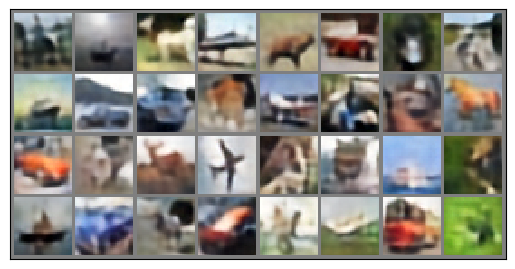

In [24]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

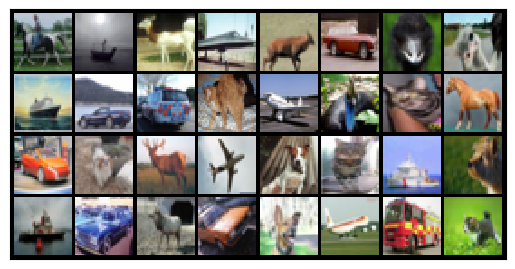

In [25]:
show(make_grid(valid_originals.cpu()+0.5))